<a href="https://colab.research.google.com/github/danplotkin/LSTM_Time_Series/blob/main/TimeSeriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import io
import copy
from sklearn.metrics import mean_squared_error
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.manual_seed(42)

# Load Data

In [ ]:
# Define the ticker symbol
ticker = "MSFT"

# Set the start and end dates for the data
start_date = "2000-01-01"
end_date = "2023-04-30"

# Download the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.282246,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,35.056648,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.426258,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,34.239563,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.687004,62013600


In [ ]:
df = data.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df.head()

,Adj Close
Date,
2000-01-03,36.282246
2000-01-04,35.056648
2000-01-05,35.426258
2000-01-06,34.239563
2000-01-07,34.687004


# Plot Adj Closing Price Over Time

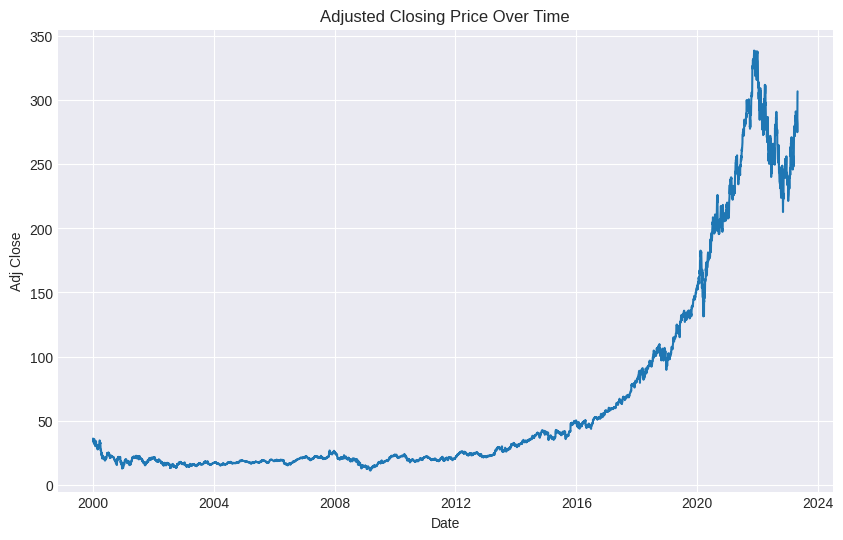

In [ ]:
plt.plot(df.index, df['Adj Close'])
plt.title('Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

# Prepare Data

In [ ]:
def prepare_df(df, window_size, future_steps):
  df = df.copy()

  for i in range(1, window_size + 1):
    df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

  for i in range(1, future_steps):
    df[f'Adj Close(t+{i})'] = df['Adj Close'].shift(-i)

  return df.dropna()

In [ ]:
window_size = 5
future_steps = 5
dataset = prepare_df(df, window_size=window_size, future_steps=future_steps)
X = dataset.iloc[:, 1:6].iloc[:, ::-1]
y = dataset.iloc[:, 6:]
dataset = pd.concat([X, dataset.iloc[:, 0], y], axis=1)
dataset.head()

,Adj Close(t-5),Adj Close(t-4),Adj Close(t-3),Adj Close(t-2),Adj Close(t-1),Adj Close,Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4)
Date,,,,,,,,,,
2000-01-10,36.282246,35.056648,35.426258,34.239563,34.687004,34.939919,34.045002,32.936134,33.558647,34.939919
2000-01-11,35.056648,35.426258,34.239563,34.687004,34.939919,34.045002,32.936134,33.558647,34.939919,35.893169
2000-01-12,35.426258,34.239563,34.687004,34.939919,34.045002,32.936134,33.558647,34.939919,35.893169,33.305744
2000-01-13,34.239563,34.687004,34.939919,34.045002,32.936134,33.558647,34.939919,35.893169,33.305744,32.994473
2000-01-14,34.687004,34.939919,34.045002,32.936134,33.558647,34.939919,35.893169,33.305744,32.994473,32.294121


In [ ]:
train, val = train_test_split(dataset, test_size=0.1, shuffle=False) # do not shuffle

In [ ]:
scaler = MinMaxScaler().fit(train) # fit scaler

### Create a PyTorch Dataset

In [ ]:
class MicrosoftDataset(Dataset):
  def __init__(self, dataset, scaler):
    dataset = scaler.transform(dataset)
    X, y = dataset[:, :future_steps], dataset[:, future_steps:]
    self.X = torch.tensor(np.expand_dims(X, axis=-1)).float()
    self.y = torch.tensor(y).float()

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
# load in datasets
train_ds = MicrosoftDataset(train, scaler)
val_ds = MicrosoftDataset(val, scaler)

# batch into dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
print(f'Train Loader Size: {len(train_loader)} \nValid Loader Size: {len(val_loader)}')

Train Loader Size: 165 
Valid Loader Size: 19


In [ ]:
ex_in, ex_out = next(iter(train_loader))
print(ex_in.shape, ex_out.shape)

torch.Size([32, 5, 1]) torch.Size([32, 5])


# Define Model

In [ ]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 5
NUM_LAYERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, device):
    super(LSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

# Create Early Stopper

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""
    
  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

# Create Trainer

In [ ]:
class Trainer:
  def __init__(self, 
               train_loader, 
               val_loader, 
               criterion, 
               optimizer, 
               model,
               device,
               max_epochs):
    self.train_loader = train_loader 
    self.val_loader = val_loader
    self.criterion = criterion
    self.optimizer = optimizer
    self.model = model.to(device)
    self.device = device
    self.early_stopper = EarlyStopping(patience=10)
    self.max_epochs = max_epochs
    self.history = {}
    self.output_dir = '/content/drive/MyDrive/Models/TimeSeriesLSTM_Multistep'
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


  def _train_epoch(self):
    self.model.train()
    running_loss = 0.00
    for batch_idx, (input, truth) in enumerate(self.train_loader):
      input, truth = input.to(self.device), truth.to(self.device)
      self.optimizer.zero_grad()
      pred = self.model(input)
      loss = self.criterion(pred, truth)
      loss.backward()
      self.optimizer.step()
      running_loss+=loss.item()
    
    return running_loss/len(self.train_loader)

  @torch.no_grad()
  def _eval_epoch(self):
    self.model.eval()
    running_loss = 0.00
    for batch_idx, (input, truth) in enumerate(self.val_loader):
      input, truth = input.to(self.device), truth.to(self.device)
      pred = self.model(input)
      loss = self.criterion(pred, truth)
      running_loss+=loss.item()
    return running_loss/len(self.val_loader)

  def train(self):
    best_val_loss = np.inf
    best_epoch = 0

    train_losses, val_losses = [], []
    for epoch in range(self.max_epochs):
      print(f'Epoch {epoch+1}/{self.max_epochs}:')

      tloss = self._train_epoch()
      train_losses.append(tloss)
      print(f'Train loss: {tloss:.4f}')
  
      vloss = self._eval_epoch()
      val_losses.append(vloss)
      print(f'Val loss: {vloss:.4f}')
      
      self.scheduler.step(vloss)

      if vloss < best_val_loss:
        best_val_loss = vloss
        best_epoch = epoch + 1

      if self.early_stopper(self.model, vloss):
        print(f'best epoch: {best_epoch}')
        break

      print()

    print('Training Finished')
    torch.save(self.model, self.output_dir)
    
    self.history = {'train': train_losses, 'val': val_losses}

  def evaluate(self):
    vloss = self._eval_epoch()
    return np.round(vloss, 4)

# Train Model

In [ ]:
model = LSTM(
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS,
    DEVICE
)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)

In [ ]:
model(ex_in).shape

torch.Size([32, 5])

In [ ]:
trainer = Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    model=model,
    device=DEVICE,
    max_epochs=250
)

trainer.train()

Epoch 1/250:
Train loss: 0.0538
Val loss: 1.3503

Epoch 2/250:
Train loss: 0.0531
Val loss: 1.3446

Epoch 3/250:
Train loss: 0.0525
Val loss: 1.3389

Epoch 4/250:
Train loss: 0.0519
Val loss: 1.3332

Epoch 5/250:
Train loss: 0.0513
Val loss: 1.3274

Epoch 6/250:
Train loss: 0.0507
Val loss: 1.3217

Epoch 7/250:
Train loss: 0.0501
Val loss: 1.3158

Epoch 8/250:
Train loss: 0.0496
Val loss: 1.3099

Epoch 9/250:
Train loss: 0.0490
Val loss: 1.3039

Epoch 10/250:
Train loss: 0.0485
Val loss: 1.2978

Epoch 11/250:
Train loss: 0.0479
Val loss: 1.2917

Epoch 12/250:
Train loss: 0.0475
Val loss: 1.2854

Epoch 13/250:
Train loss: 0.0469
Val loss: 1.2790

Epoch 14/250:
Train loss: 0.0464
Val loss: 1.2726

Epoch 15/250:
Train loss: 0.0459
Val loss: 1.2660

Epoch 16/250:
Train loss: 0.0455
Val loss: 1.2593

Epoch 17/250:
Train loss: 0.0450
Val loss: 1.2526

Epoch 18/250:
Train loss: 0.0446
Val loss: 1.2458

Epoch 19/250:
Train loss: 0.0442
Val loss: 1.2389

Epoch 20/250:
Train loss: 0.0437
Val los

In [ ]:
trainer.evaluate()

0.0034

In [ ]:
lstm_model = torch.load('/content/drive/MyDrive/Models/TimeSeriesLSTM_Multistep').to(DEVICE)

# Get Model RMSE

In [ ]:
class TimeSeriesForecast:
  def __init__(self, lstm_model, device, scaler, val_data):
    self.model = lstm_model
    self.device = device
    self.scaler = scaler
    self.val_data = val_data

  @torch.no_grad()
  def _predict(self, idx):
    X, y = self.val_data.__getitem__(idx)
    X = X.unsqueeze(0).to(self.device)
    preds = self.model(X)
    return X.flatten(), y, preds.flatten(),

  def _get_unormalized(self, idx):
    X, truth, preds = self._predict(idx)
    truth_row = torch.concat([X, truth])
    truth_row = truth_row.detach().numpy().reshape(1, -1)
    preds_row = torch.concat([X, preds])
    preds_row = preds_row.detach().numpy().reshape(1, -1)
    return self.scaler.inverse_transform(truth_row), self.scaler.inverse_transform(preds_row)

  def get_predictions(self):
    truth, preds = [], []
    for i, (input, output) in enumerate(self.val_data):
      truth_row, preds_row = self._get_unormalized(i)
      truth.extend(truth_row.flatten()[future_steps:])
      preds.extend(preds_row.flatten()[future_steps:])

    return truth, preds

  def rmse(self):
    truth, preds = self.get_predictions()
    mse = mean_squared_error(truth, preds)
    return np.sqrt(mse)    

In [ ]:
ts = TimeSeriesForecast(lstm_model, DEVICE, scaler, val_ds)

In [ ]:
print(f'Validation Root Mean Squared Error: {ts.rmse():.4f}')

Validation Root Mean Squared Error: 12.6657


This means that for every prediction step, the model on average is $12.67 off the actual adjusted closing price.